# Part 1: Domain Adaptation

model is trained on movie reviews and is adapted to classify restaurant reviews

## Lib & Dependencies

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import AdamW
from transformers import AutoTokenizer, PreTrainedModel, GPT2Model, AutoConfig

import time
from tqdm import tqdm

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data

Sample a total of 15,000 rows, with 3-star having double the number of rows.

This is done to ensure that the final dataset is balanced across all classes after combining:
- 1-star and 2-star classes
- 4-star and 5-star classes

In [26]:
max_rows_per_star = {1: 2500, 2: 2500, 3: 5000, 4: 2500, 5: 2500}  # Set max rows per star value
target_total_rows = 15000  # Total rows
chunk_size = 10000  # Size of each chunk

# Create a dictionary to hold the sampled data for each star value
sample_dict = {star: pd.DataFrame() for star in range(1, 6)} 

for chunk in pd.read_json('data/yelp_academic_dataset_review.json', lines=True, chunksize=chunk_size):
    for star in sample_dict.keys():
        star_chunk = chunk[chunk['stars'] == star]
        
        # If we need more rows for this star, append the necessary ones
        if len(sample_dict[star]) < max_rows_per_star[star]:
            remaining_rows = max_rows_per_star[star] - len(sample_dict[star])
            sample_dict[star] = pd.concat([sample_dict[star], star_chunk.head(remaining_rows)], ignore_index=True)

    total_collected = sum(len(sample_dict[s]) for s in sample_dict.keys())
    if total_collected >= target_total_rows:
        break

sample_df = pd.concat(sample_dict.values(), ignore_index=True)

if len(sample_df) > target_total_rows:
    df = sample_df.sample(n=target_total_rows, random_state=42)
else:
    df = sample_df

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
print("The Shape of the Dataset".format(),df.shape)

The Shape of the Dataset (15000, 9)


## EDA

C:\Users\yauju\AppData\Local\Temp\ipykernel_30276\997926761.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df3, palette='viridis')


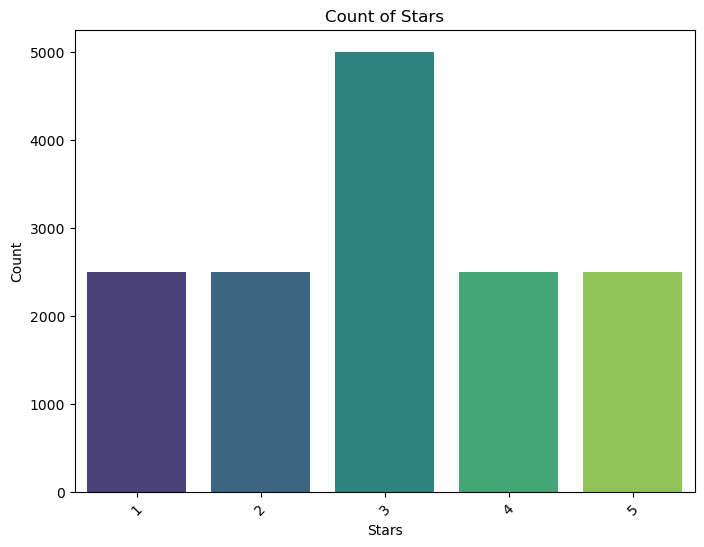

In [36]:
plt.figure(figsize=(8, 6))
sns.countplot(x='stars', data=df, palette='viridis')
plt.title('Count of Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Data Cleaning

In [81]:
df.duplicated().sum()

0

In [82]:
df.drop_duplicates(inplace=True)

## Preprocessing

In [85]:
# Map the original star ratings to new class labels
mapping = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}
df['stars'] = df['stars'].map(mapping)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['stars'], test_size=0.2, random_state=42)
num_labels = 3

## Model

base model class

In [87]:
class DistilGPT2ForBinaryClassification(GPT2Model):
    def __init__(self, num_labels):
        config = AutoConfig.from_pretrained("distilgpt2")
        super().__init__(config)
        self.distil_gpt2 = GPT2Model.from_pretrained("distilgpt2", config=config)
        self.classifier = nn.Linear(config.n_embd, 1)

        self.post_init()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distil_gpt2(input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs['last_hidden_state'][:,-1,:])
        probabilities = torch.sigmoid(logits)
        return probabilities

In [88]:
class DistilGPT2ForSequenceClassification(nn.Module):
    def __init__(self, num_labels):
        super(DistilGPT2ForSequenceClassification, self).__init__()

         # Load the saved model
        self.distil_gpt2 = DistilGPT2ForBinaryClassification.from_pretrained("./saved_model/model_distilgpt2/")
        # modify the last layer
        self.distil_gpt2.classifier = nn.Linear(self.distil_gpt2.config.hidden_size, num_labels)

        # # Optional: Freeze the model weight except for the last layer
        # for param in self.distil_gpt2.parameters():
        #     param.requires_grad = False
        # for param in self.distil_gpt2.classifier.parameters():
        #     param.requires_grad = True
            
    def forward(self, input_ids, attention_mask=None):
        outputs = self.distil_gpt2(input_ids, attention_mask=attention_mask)
        return outputs

In [89]:
class IMDbDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        sentiment = self.sentiments.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [90]:
MAX_LEN = 256
BATCH_SIZE = 32

train_dataset = IMDbDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = IMDbDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [91]:
model = DistilGPT2ForSequenceClassification(num_labels)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [94]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    train_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, sentiments)
        
        # Accumulate the loss
        train_loss += loss.item()
        
        # Calculate accuracy
        predicted_classes = outputs.argmax(dim=1)
        correct_predictions += (predicted_classes == sentiments).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct_predictions / len(data_loader.dataset), train_loss / len(data_loader)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, sentiments)
            
            test_loss += loss.item() 
            predicted_classes = outputs.argmax(dim=1)
            correct_predictions += (predicted_classes == sentiments).sum().item()
        
    return correct_predictions / len(data_loader.dataset), test_loss / len(data_loader)

In [95]:
EPOCHS = 3

times = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    test_acc, test_loss = evaluate_model(model, test_loader, device)
    print(f'Test loss: {test_loss}, accuracy: {test_acc}')
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    
    time_taken = time.time()-start_time
    print(f'time taken: {time_taken}')
    times.append(time_taken)

Epoch 1/3


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [21:11<00:00,  3.39s/it]

Train loss: 0.8401168511708578, accuracy: 0.66825


Test loss: 0.794946347779416, accuracy: 0.731
time taken: 1334.926574230194
Epoch 2/3


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [20:57<00:00,  3.35s/it]


Train loss: 0.7747080977757772, accuracy: 0.7525
Test loss: 0.7736528820179879, accuracy: 0.7463333333333333
time taken: 1316.4188766479492
Epoch 3/3


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [20:59<00:00,  3.36s/it]


Train loss: 0.7513870922724406, accuracy: 0.77925
Test loss: 0.7774898378138847, accuracy: 0.755
time taken: 1320.7790348529816


In [122]:
# Evaluate the model on test set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get predicted classes
        predicted_classes = outputs.argmax(dim=1).cpu().numpy()
        
        # Extend lists with predictions and true values
        y_pred.extend(predicted_classes)
        y_true.extend(sentiments.cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78      1006
           1       0.64      0.68      0.66       983
           2       0.78      0.88      0.83      1011

    accuracy                           0.76      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.76      0.76      0.76      3000



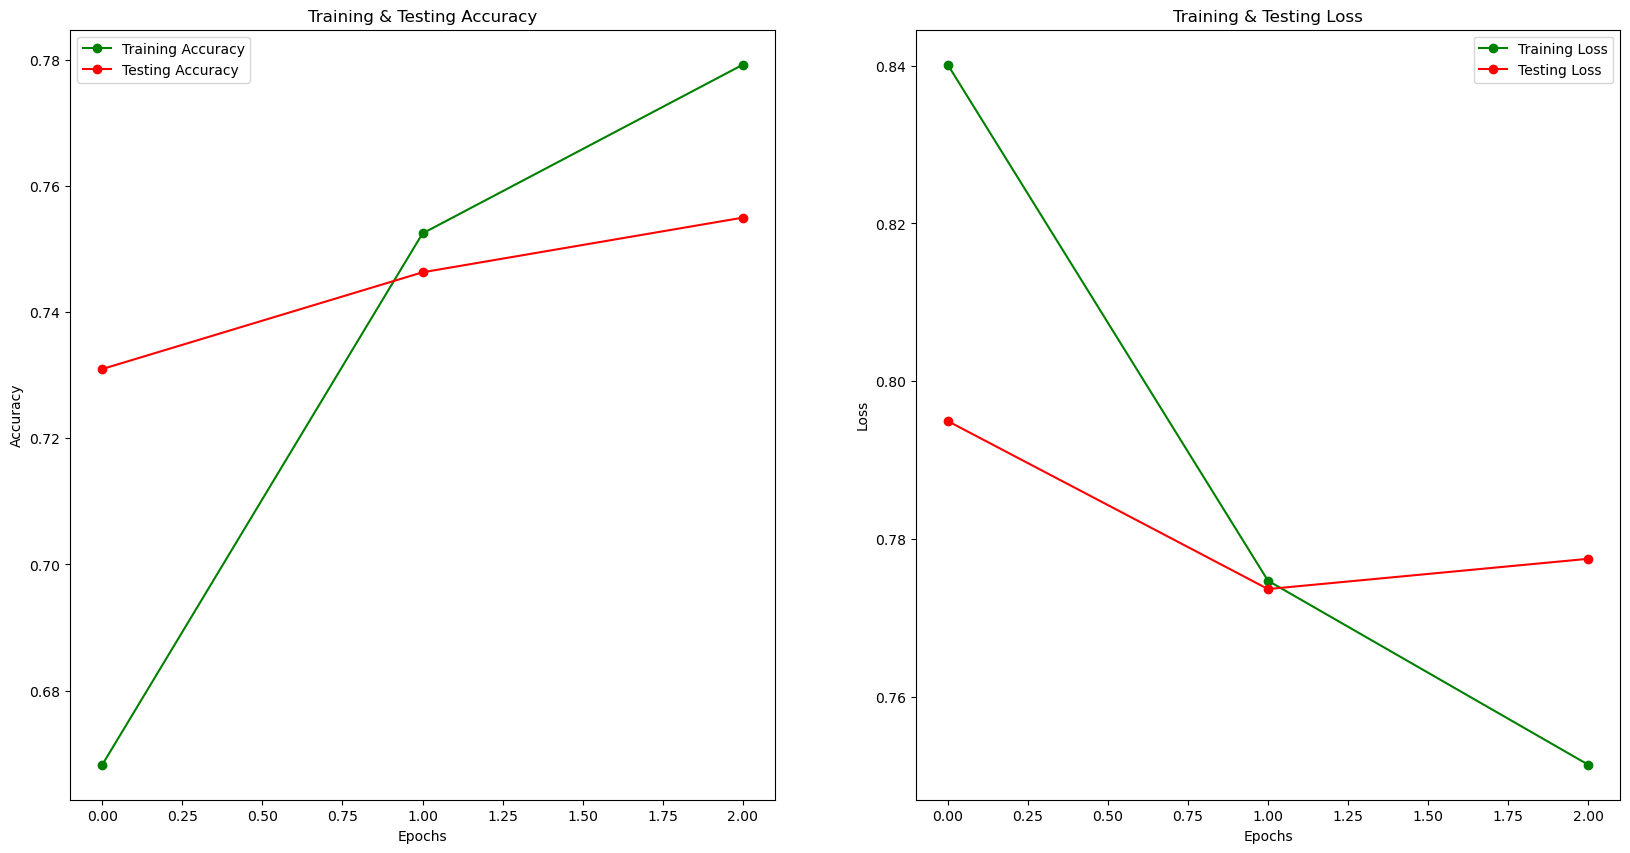

In [127]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs, 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_accs, 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , test_losses , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [129]:
print(f'train_accs: {train_accs}')
print(f'test_accs: {test_accs}')
print(f'train_losses: {train_losses}')
print(f'test_losses: {test_losses}')

train_accs: [0.66825, 0.7525, 0.77925]
test_accs: [0.731, 0.7463333333333333, 0.755]
train_losses: [0.8401168511708578, 0.7747080977757772, 0.7513870922724406]
test_losses: [0.794946347779416, 0.7736528820179879, 0.7774898378138847]


Text(95.72222222222221, 0.5, 'Actual')

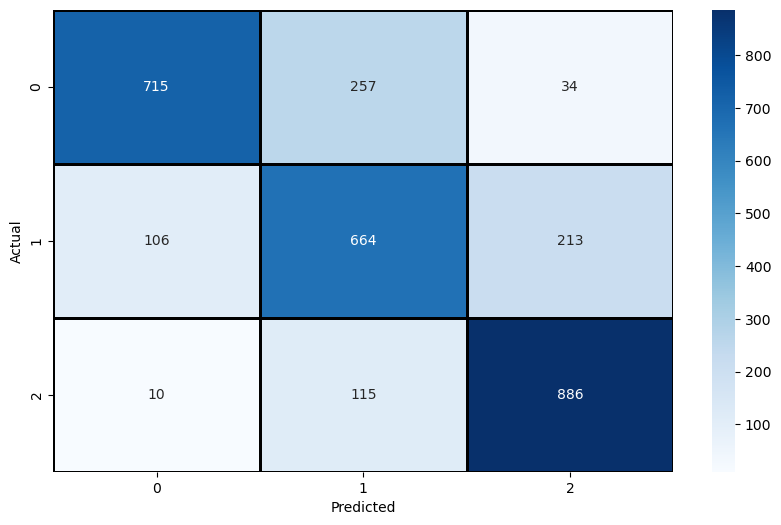

In [131]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = [i for i in range(3)] , yticklabels = [i for i in range(3)])
plt.xlabel("Predicted")
plt.ylabel("Actual")

performs better than 5-label classes